# Hypothesis Testing - Yulu

### Test used: 
#### 1. Mann-Whitney U test
#### 2. kruskal
#### 3. Chi-Square Statistic 

In [1]:
#Libraries import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import chi2_contingency

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Dataset import
data = pd.read_csv("../pra_datasets/yulu_bike_sharing_dataset.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# We can drop 'workingday' as 'holiday' already indicates the same, and 'atemp' as it provides redundant information with 'temp'
data = data.drop(data[['workingday','atemp']],axis=1)
data.head()

,datetime,season,holiday,weather,temp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,1,9.84,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,1,9.02,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,1,9.02,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,1,9.84,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,1,9.84,75,0.0,0,1,1


## Exploratory Data Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   humidity    10886 non-null  int64  
 6   windspeed   10886 non-null  float64
 7   casual      10886 non-null  int64  
 8   registered  10886 non-null  int64  
 9   count       10886 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 850.6+ KB


### 1. Distribution of observations across count

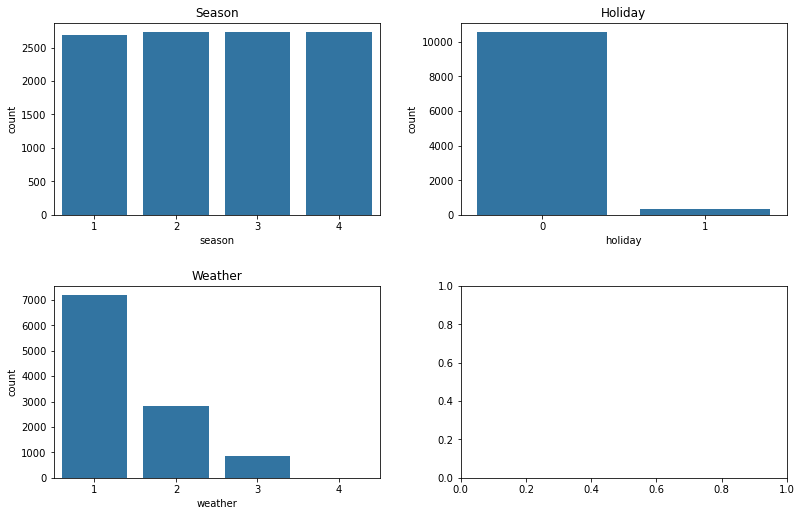

In [5]:
columns = ['season','holiday','weather']
fig, ax = plt.subplots(2,2,figsize=(12,8))
fig.tight_layout(pad=5.0)
i = 0;j= 0
for column in columns:
    plot_df = sns.countplot(data=data,x=column,ax=ax[i,j])
    plot_df.set_title(str.capitalize(column))
    j=j+1
    if j%2==0:i=i+1;j=0

<div class="alert alert-block alert-success">
<b>Seasonal effects on sales seem minimal. Bike rentals are highest on working days, particularly during clear or partly cloudy weather, indicating a reluctance to rent bikes in inclement conditions. </b>
</div>

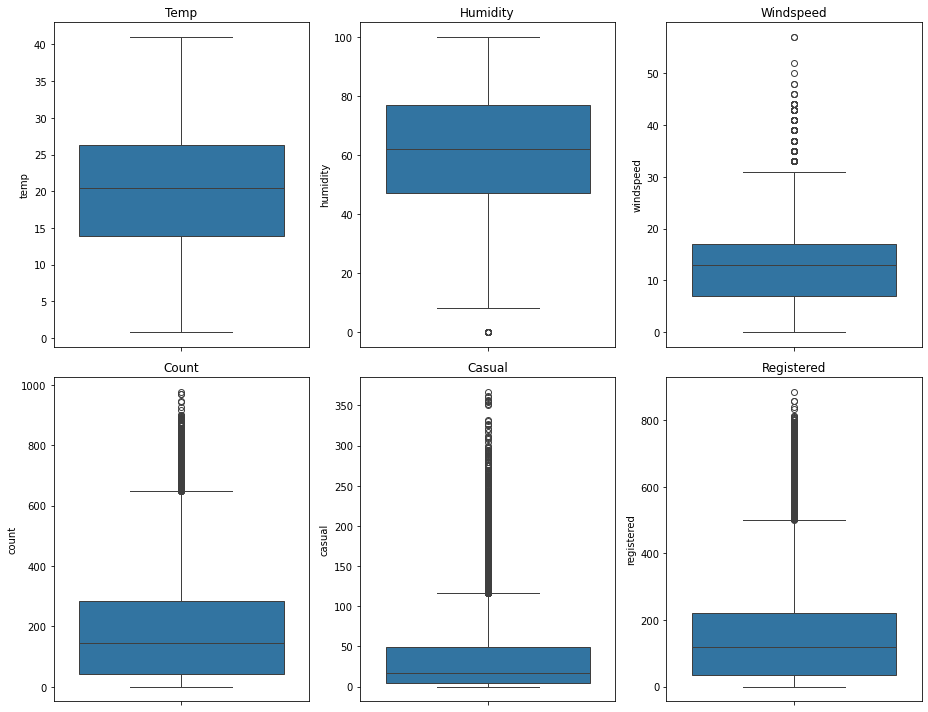

In [6]:
columns = ['temp','humidity','windspeed','count','casual','registered']
fig, ax = plt.subplots(2, 3, figsize=(13, 10))

for i, column in enumerate(columns):
    plot_df = sns.boxplot(data=data, y=column, ax=ax[i//3, i%3])  # Adjusting indexing
    plot_df.set_title(column.capitalize())

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Temperature and humidity exhibit a normal distribution, whereas windspeed and count data are right-skewed. Given that casual and registered users are subsumed within the count, we can temporarily disregard them. Let's proceed by removing these outliers. </b>
</div>

In [7]:
# Drop outliers
columns_to_check = ['windspeed', 'count', 'casual', 'registered']
threshold_multiplier = 1.5

for column in columns_to_check:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold_multiplier * IQR
    upper_bound = Q3 + threshold_multiplier * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

data.reset_index(drop=True, inplace=True)
data.shape

(9238, 10)

### 2. Correlation

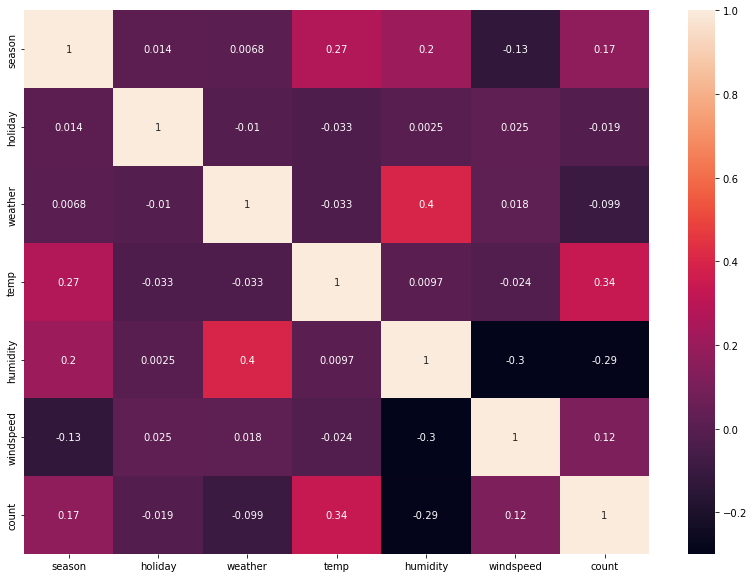

In [8]:
fig, ax = plt.subplots(figsize=(14,10))
df_corr = sns.heatmap(data.drop(columns=['datetime','casual','registered']).corr(), annot=True,ax=ax)

<div class="alert alert-block alert-success">
<b>Elevated humidity tends to correspond to lower counts, whereas higher temperatures typically lead to better counts, particularly in the range of 30% to 40%. </b>
</div>

## Test 1:
#### Working Day Effect on Electric Cycle Demand:
- Null Hypothesis (H0): There is no significant effect of working day on the number of electric cycles rented.
- Alternate Hypothesis (H1): Working day significantly affects the number of electric cycles rented.
    - Mann-Whitney U test, If the p-value is less than 0.05, reject the null hypothesis.
    - Mann-Whitney U test, is a non-parametric test that does not assume normality or equal variances.

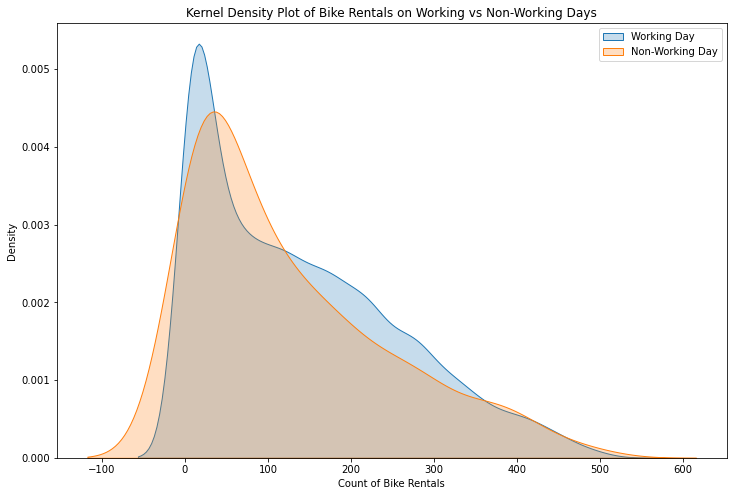

In [9]:
working_day = data.loc[data['holiday']==0,'count']
non_working_day = data.loc[data['holiday']==1,'count']

# Setting the figure size
plt.figure(figsize=(12, 8))

# Plotting
sns.kdeplot(working_day, label='Working Day', fill=True)
sns.kdeplot(non_working_day, label='Non-Working Day', fill=True)

# Adding labels and title
plt.xlabel('Count of Bike Rentals')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Bike Rentals on Working vs Non-Working Days')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [10]:
# Perform Mann-Whitney U test
stat, p = mannwhitneyu(working_day, non_working_day)

# Print results
print("Mann-Whitney U Test: U =", stat, ", p =", p)

Mann-Whitney U Test: U = 1189656.5 , p = 0.055234376218554995


<div class="alert alert-block alert-success">
<b>Here p vale is greater than our threshold hence we have to accept the null hypothesis that means, There is no significant effect of working day on the number of electric cycles rented. </b>
</div>

## Test 2
#### Seasonal Differences in Cycle Demand:
- Null Hypothesis (H0): The number of cycles rented is similar across different seasons.
- Alternate Hypothesis (H1): The number of cycles rented varies across different seasons.

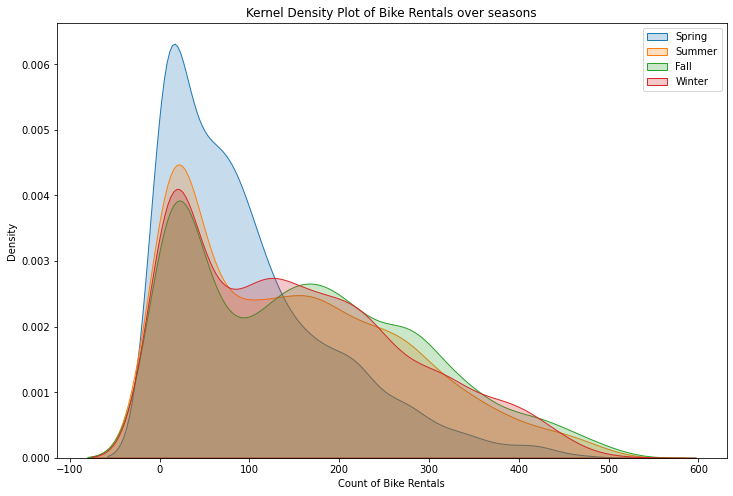

In [11]:
# Separate data into different seasons
spring_data = data[data['season'] == 1]['count']
summer_data = data[data['season'] == 2]['count']
fall_data = data[data['season'] == 3]['count']
winter_data = data[data['season'] == 4]['count']

# Setting the figure size
plt.figure(figsize=(12, 8))

# Plotting
sns.kdeplot(spring_data, label='Spring', fill=True)
sns.kdeplot(summer_data, label='Summer', fill=True)
sns.kdeplot(fall_data, label='Fall', fill=True)
sns.kdeplot(winter_data, label='Winter', fill=True)

# Adding labels and title
plt.xlabel('Count of Bike Rentals')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Bike Rentals over seasons')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [12]:
# Perform Kruskal-Wallis H test
stat, p = kruskal(spring_data, summer_data, fall_data, winter_data)

# Print results
print("Kruskal-Wallis H Test: H =", stat, ", p =", p)

Kruskal-Wallis H Test: H = 386.178944540724 , p = 2.1815355496329382e-83


<div class="alert alert-block alert-success">
<b>Here p is very smaller than our threshold hence we reject the null hypothesis that means, The number of cycles rented varies across different seasons. </b>
</div>

## Test 3
#### Weather Impact on Cycle Demand:
- Null Hypothesis (H0): The number of cycles rented is similar across different weather conditions.
- Alternate Hypothesis (H1): The number of cycles rented varies across different weather conditions.

/tmp/ipykernel_139475/2192138751.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(weather_4_data, label='Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog', fill=True)


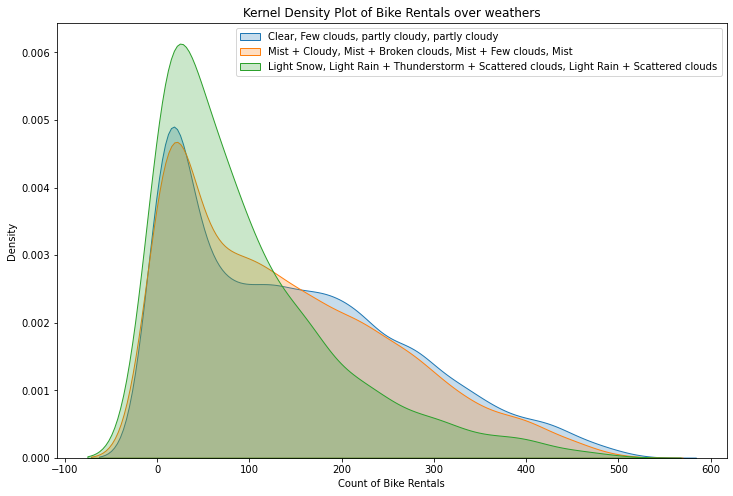

In [13]:
# Separate data into different weather conditions
weather_1_data = data[data['weather'] == 1]['count']
weather_2_data = data[data['weather'] == 2]['count']
weather_3_data = data[data['weather'] == 3]['count']
weather_4_data = data[data['weather'] == 4]['count']

# Setting the figure size
plt.figure(figsize=(12, 8))

# Plotting
sns.kdeplot(weather_1_data, label='Clear, Few clouds, partly cloudy, partly cloudy', fill=True)
sns.kdeplot(weather_2_data, label='Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', fill=True)
sns.kdeplot(weather_3_data, label='Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', fill=True)
sns.kdeplot(weather_4_data, label='Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog', fill=True)

# Adding labels and title
plt.xlabel('Count of Bike Rentals')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Bike Rentals over weathers')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [14]:
# Perform Kruskal-Wallis H test
stat, p = kruskal(weather_1_data, weather_2_data, weather_3_data, weather_4_data)

# Print results
print("Kruskal-Wallis H Test: H =", stat, ", p =", p)

Kruskal-Wallis H Test: H = 110.01085965187343 , p = 1.0914364790471886e-23


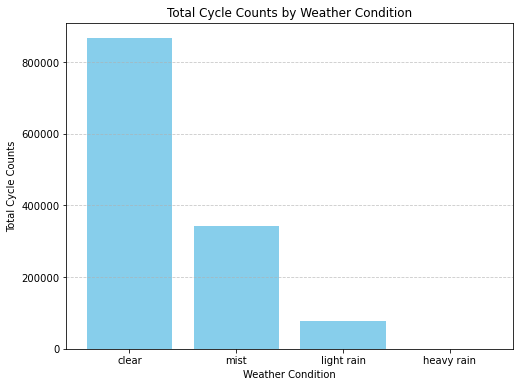

In [15]:
# Group data by weather condition and calculate total counts
weather_counts = data.groupby('weather')['count'].sum()

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(weather_counts.index, weather_counts.values, color='skyblue')
plt.title('Total Cycle Counts by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Total Cycle Counts')
plt.xticks(weather_counts.index, ['clear', 'mist', 'light rain', 'heavy rain'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<div class="alert alert-block alert-success">
<b>Here p is very smaller than our threshold hence we reject the null hypothesis that means, The number of cycles rented varies across different weather conditions. </b>
</div>

## Test 4
#### Weather Dependence on Season:
- Null Hypothesis (H0): Weather conditions are independent of the season.
- Alternate Hypothesis (H1): Weather conditions are dependent on the season.

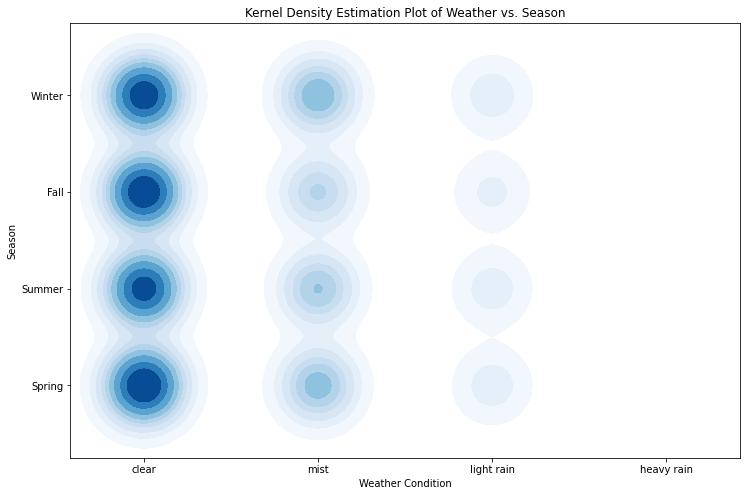

In [16]:
# Create the KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(x='weather', y='season', data=data, fill=True, cmap='Blues', thresh=0.05)
plt.title('Kernel Density Estimation Plot of Weather vs. Season')
plt.xlabel('Weather Condition')
plt.ylabel('Season')
plt.xticks(ticks=[1, 2, 3, 4], labels=['clear', 'mist', 'light rain', 'heavy rain'])
plt.yticks(ticks=[1, 2, 3, 4], labels=['Spring', 'Summer', 'Fall', 'Winter'])
plt.show()

In [17]:
# Create a contingency table of weather and season
contingency_table = pd.crosstab(data['weather'], data['season'])

# Perform chi-square test of independence
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print results
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)


Chi-Square Statistic: 49.24295874594975
p-value: 1.4945044640445612e-07


<div class="alert alert-block alert-success">
<b>Here p is very smaller than our threshold hence we reject the null hypothesis that means, Weather conditions are dependent on the season. </b>
</div>

### Results
- Working Day Effect on Electric Cycle Demand:
    - No, their is no significant effect of working day on the number of electric cycles rented.
- Seasonal Differences in Cycle Demand:
    - Yes, the number of cycles rented varies across different seasons.
- Weather Impact on Cycle Demand:
    - Yes, the number of cycles rented varies across different weather conditions.
- Weather Dependence on Season:
    - Yes, weather conditions are dependent on the season.

<div class="alert alert-block alert-warning">
<b>END </b>
</div>